In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from ML_utils import load_data,total_charges_grouping
df =pd.read_csv('train.csv')



total_charges_grouping_on = True
one_hot_on = True
normalize_on = True
oversample_on=True


df=total_charges_grouping(df,grouping=total_charges_grouping)
exclude_list = ['state']
# exclude_list = [feature_name for feature_name in df.columns if feature_name not in['number_vmail_messages','number_customer_service_calls','total_charges','churn']]


###################
#### LOAD DATA ####
X_train,y_train,X_val,y_val,columns = load_data(df,exclude=exclude_list,one_hot=one_hot_on,normalize_=normalize_on,oversample=oversample_on)




ModuleNotFoundError: No module named 'ML_utils'

In [11]:
def reLU(z):
    return np.maximum(0,z)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def reLU_derivative(z):
    return z>0

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))


def squared_error(y,A):
    return np.sum((y-A)**2)/y.shape[0]

def initialize_parameters(model):
    W=[]
    b=[]
    for i in range(1,len(model)):
        W.append(np.random.rand(model[i-1],model[i]) - 0.5)
        b.append(np.random.rand(1,model[i]) - 0.5)
    return W,b

def update_parameters(W,b,dW,db,learning_rate):
    for i in range(len(W)):
        W[i]=W[i]-learning_rate*dW[i]
        b[i]=b[i]-learning_rate*db[i]
    return W,b


def dense_layer(X,W,b, use_sigmoid=False):
    z=np.matmul(X,W)+b 
    return sigmoid(z) if use_sigmoid else reLU(z)



In [12]:
def forward_propagation(X,W,b):
    A=[]
    prev_A=X
    for i in range(len(W)):
        prev_A=dense_layer(prev_A,W[i],b[i], use_sigmoid=(i==len(W)-1))
        A.append(prev_A)
    return A     
    
    


In [13]:
def back_propagation(X,y,A,W,alpha=0.01):
    dW=[]
    db=[]
    m=y.shape[0]
    
    #### CALCULATING dC/dA
    dA=(A[-1]-y)
    #### CALCULATING dC/dZ by using the chain rules
    dZ=dA*sigmoid_derivative(A[-1])
    
    #### CALCULATING dC/dW and alpha * W is the regularization term
    dC_dW = (A[-2].T.dot(dZ)+alpha * W[-1])/m
    dW.append(dC_dW)
    
    #### CALCULATING dC/db
    
    dC_db=np.sum(dZ,axis=0,keepdims=True)/m
    db.append(dC_db)
  
  ## Loop through the hidden layers to calculate dW and db
    for i in range(len(W)-2,0,-1):
       
        dC_dA=dZ.dot(W[i+1].T)
        dA_dZ=reLU_derivative(A[i])
        dZ=dC_dA*dA_dZ
        dW.append((A[i-1].T.dot(dZ)+alpha * W[i])/m)
        db.append(np.sum(dZ,axis=0,keepdims=True)/m)
        
    ### Calculate the final dot product with X
    dZ=dZ.dot(W[1].T)*reLU_derivative(A[0])
    dW.append((X.T.dot(dZ)+alpha * W[0])/m)
    db.append(np.sum(dZ,axis=0,keepdims=True)/m)
    
    ### return the inverse of dW and db because we calculated them in reverse order
    return dW[::-1],db[::-1]


In [14]:
def train(X_train,y_train,X_valid,y_valid,learning_rate,epochs,alpha,model):
    costs_train=[]
    costs_valid=[]
    W,b=initialize_parameters(model)
    for i in range(epochs):
        
        A=forward_propagation(X_train,W,b)
        
        dW,db=back_propagation(X_train,y_train,A,W,alpha)
        
        W,b=update_parameters(W,b,dW,db,learning_rate)
        
        loss=squared_error(y_train,A[-1])
        loss_valid=squared_error(y_valid,forward_propagation(X_valid,W,b)[-1])
        costs_train.append(loss)
        acc=accuracy_score(y_valid,np.round(forward_propagation(X_valid,W,b)[-1]))
        costs_valid.append(loss_valid)
        
        if acc == 1:
            break
        
        acc_valid=accuracy_score(y_valid,np.round(forward_propagation(X_valid,W,b)[-1]))
        
    return W,b,costs_train,costs_valid,acc_valid

In [15]:
def grid_search(X_train, y_train, X_val, y_val, model_list, lr_list, alpha_list, threshold_list, epoch_list):
        best_accuracy = 0
        best_model=[]
        layer_cost_train = [] 
        layer_cost_valid=[] 
        model_values = [] 
       

        for model in model_list: 
            for lr in lr_list:
                for alpha in alpha_list:
                    for epoch in epoch_list:
                        for threshold in threshold_list:
                            W,b,costs_train,costs_valid,acc_valid=train(X_train,y_train,X_val,y_val,lr,epoch,alpha,model)
                            model_values.append({"model": model, "lr": lr, "alpha": alpha, "epoch": epoch, "threshold": threshold})
                            layer_cost_train.append([costs_train])
                            layer_cost_valid.append([costs_valid])
                            
                
                            if acc_valid > best_accuracy:
                                best_accuracy = acc_valid
                                best_lr = lr
                                best_alpha = alpha
                                best_threshold = threshold
                                W_best = W
                                b_best = b
                                best_model=model
                                best_epoch=epoch
        
        print(f"Best Accuracy: {best_accuracy}")
        print(f"Best Model: {best_model}") 
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Learning Rate: {best_lr}")
        print(f"Best Alpha: {best_alpha}")
        print(f"Best Threshold: {best_threshold}")
        
        
        return {"best_accuracy": best_accuracy, "best_model": best_model,"best_epoch":best_epoch, "best_lr": best_lr, "best_alpha": best_alpha, "best_threshold": best_threshold, "W_best": W_best, "b_best": b_best, "layer_cost_train": layer_cost_train, "layer_cost_valid": layer_cost_valid, "model_values": model_values}
                                

In [16]:
model_list=[[X_train.shape[1],64,1]]
lr_list = [0.1]
alpha_list = [0.1]
threshold_list = [0.5]
epoch_list= [10000]

results=grid_search(X_train,y_train,X_val,y_val,model_list,lr_list,alpha_list,threshold_list,epoch_list)



Best Accuracy: 0.9075975359342916
Best Model: [14, 64, 1]
Best Epoch: 10000
Best Learning Rate: 0.1
Best Alpha: 0.1
Best Threshold: 0.5


In [17]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=10000, alpha=0.1, solver='adam')

clf.fit(X_train, y_train)

/home/2fps/miniconda3/envs/conda_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(alpha=0.1, hidden_layer_sizes=(64,), max_iter=10000)

In [18]:
W_best = results['W_best']
b_best = results['b_best']
best_threshold = results['best_threshold']
y_pred=forward_propagation(X_val,W_best,b_best)[-1]
y_pred=np.where(y_pred>best_threshold,1,0)
print(f"Test accuracy: {accuracy_score(y_val,y_pred)}")

Test accuracy: 0.9075975359342916


In [19]:
clf.predict(X_val)
print(f"Test accuracy: {accuracy_score(y_val,clf.predict(X_val))}")

Test accuracy: 0.9377138945927447


Model 1:
Model values: {'model': [14, 64, 1], 'lr': 0.1, 'alpha': 0.1, 'epoch': 10000, 'threshold': 0.5}


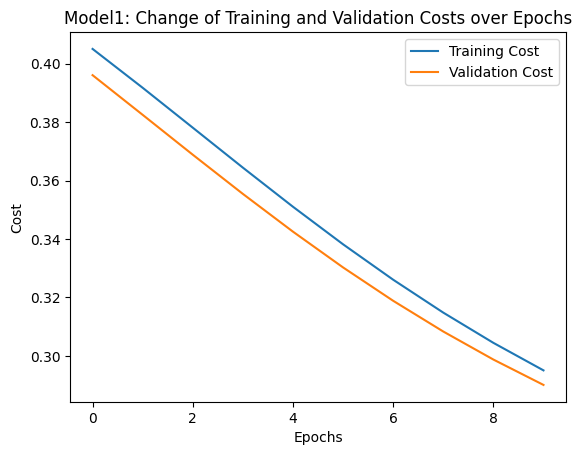

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the lists of training and validation costs
for i in range(len(results['layer_cost_train'])):
    print(f"Model {i+1}:")
    print(f"Model values: {results['model_values'][i]}")
    train_costs = results['layer_cost_train'][i]
    val_costs = results['layer_cost_valid'][i]

    # Reshape the arrays to have the same first dimension
    train_costs = np.reshape(train_costs, (-1,))
    val_costs = np.reshape(val_costs, (-1,))

    # Create the x-axis values (epochs) in the interval of 5000
    epoch_range_start=0
    epoch_range_end=10
    epochs = range(epoch_range_start, epoch_range_end, 1)

    # Plot the training and validation costs
    plt.plot(epochs, train_costs[epoch_range_start:epoch_range_end], label='Training Cost')
    plt.plot(epochs, val_costs[epoch_range_start:epoch_range_end], label='Validation Cost')

    # Add labels and title to the plot
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title(f'Model{i+1}: Change of Training and Validation Costs over Epochs')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

Model 1:
Model values: {'model': [14, 64, 1], 'lr': 0.1, 'alpha': 0.1, 'epoch': 10000, 'threshold': 0.5}


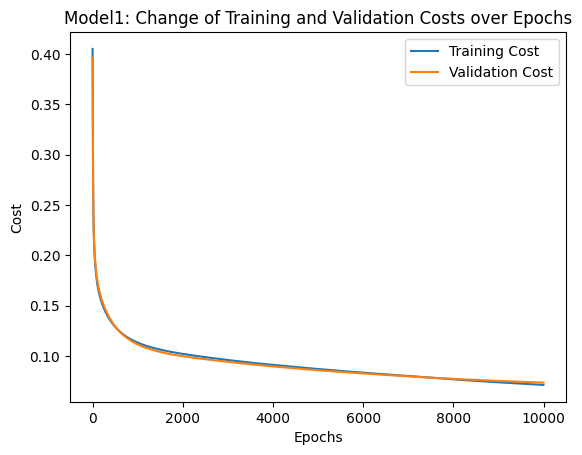

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the lists of training and validation costs
for i in range(len(results['layer_cost_train'])):
    print(f"Model {i+1}:")
    print(f"Model values: {results['model_values'][i]}")
    train_costs = results['layer_cost_train'][i]
    val_costs = results['layer_cost_valid'][i]

    # Reshape the arrays to have the same first dimension
    train_costs = np.reshape(train_costs, (-1,))
    val_costs = np.reshape(val_costs, (-1,))

    # Create the x-axis values (epochs) in the interval of 5000
    epoch_range=results['model_values'][i]['epoch']
    epochs = range(epoch_range)

    # Plot the training and validation costs
    plt.plot(epochs, train_costs[:epoch_range], label='Training Cost')
    plt.plot(epochs, val_costs[:epoch_range], label='Validation Cost')

    # Add labels and title to the plot
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title(f'Model{i+1}: Change of Training and Validation Costs over Epochs')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score

def predict(X,W,b,threshold):
    return forward_propagation(X,W,b)[-1]>threshold
precision_scores = []
recall_scores = []

best_f1=-1
threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in threshold_list:
    y_pred = predict(X_test, W_best, b_best, threshold)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Threshold: {threshold}")

    print(f"F1 score for y_test with W,b: {f1_score(y_test, y_pred)}")
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_threshold = threshold
        best_y_pred = y_pred
        best_cm = cm
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
x = np.arange(len(threshold_list))

# Plot bars

plt.bar(x - 0.3, precision_scores, 0.3, label='Precision')
plt.bar(x, recall_scores, 0.3, label='Recall')


plt.xticks(x, threshold_list)
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.title('Precision and Recall for different thresholds')
plt.legend()

plt.show()

# Plot the confusion matrix using seaborn
sns.heatmap(best_cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix for the best f1 score')
plt.show()
print(best_cm)
print(f"Best threshold: {best_threshold}")


NameError: name 'X_test' is not defined

In [ ]:
### USE THE MODEL ON THE TEST SET
df_test=pd.read_csv('test.csv')

df_test=total_day_eve_night_grouping(df_test,grouping=feature_engineering)


X_test_output=load_data_test_set(df_test,exclude=exclude_list+['id'],one_hot=one_hot_on,normalize_=normalize_on)

y_pred_output=forward_propagation(X_test_output,W_best,b_best)[-1]

y_pred_output=np.where(y_pred_output>best_threshold, 'yes', 'no')
y_pred_output=y_pred_output.reshape(-1,)
id_column = np.arange(1, y_pred_output.shape[0] + 1)


# Create a DataFrame
df_output = pd.DataFrame({
    'id': id_column,
    'churn': y_pred_output
})


# Save the DataFrame as a CSV file
df_output.to_csv('output_neural_network.csv', index=False)